In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Online appendix: BDID

This is an online appendix to paper: Bayesian causal inference in automotive software engineering

## Setting up the model

In [88]:
def model(X, obs=None):

    # Prior for the bias/intercept
    alpha = pyro.sample('alpha', dist.Normal(0., 1.))
    
    # Priors for the regression coeffcients
    beta  = pyro.sample('beta', dist.Normal(torch.zeros(X.shape[1]), 
                                            .5*torch.ones(X.shape[1]))) 
    # Priors for the error term
    epsilon = pyro.sample('epsilon', dist.HalfCauchy(0.5))  
    
    with pyro.plate('data'):
        y = pyro.sample('y', dist.Normal(alpha + X.matmul(beta), epsilon), obs=obs)
        
    return y

## Import the data

In [89]:
df = pd.read_csv('data_did_input.csv')
df.head()

,Car_id,treatment,time_period,avgEng_km,TempAvg,TempMin,TempMax,DisAvg,DisMax,CoolTempAvg,AverageActualDischargeEnergyHvBatt[Wh],StartActualDischargeEnergyHvBatt[Wh],AverageDispSoCHvBatt[%]
0,Car_3023,0,0,209.579212,18.700000,14.4,21.8,68.530769,489.8,22.730769,48836.507692,52038.461538,61.830769
1,Car_3025,0,0,207.130003,20.627778,15.8,24.7,50.888889,427.3,23.733333,62020.555556,66280.555556,78.800000
2,Car_3026,0,0,226.186932,18.628571,10.5,23.7,20.932143,100.1,22.403571,64842.014286,67266.071429,82.475000
3,Car_3028,0,0,210.327335,19.706061,14.7,25.8,20.272727,149.6,23.036364,65395.012121,67790.909091,83.036364
4,Car_3043,1,0,168.100857,21.916260,13.8,25.5,37.545528,246.3,24.659350,58516.417073,60304.065041,73.510569


In [90]:
df.shape

(352, 13)

Specifing the feature column names, and target variable.

In [91]:
featuers = ['time_period','treatment',
            'TempAvg', 'TempMin',
            'TempMax', 'DisAvg', 'DisMax', 'CoolTempAvg',
            'AverageActualDischargeEnergyHvBatt[Wh]',
            'StartActualDischargeEnergyHvBatt[Wh]', 
            'AverageDispSoCHvBatt[%]']

Preprossing the data and chaging the data format to Pyro tensor.

In [92]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()

X = MinMaxScaler.fit_transform(df[featuers])

In [93]:
target = ['avgEng_km']

y = MinMaxScaler.fit_transform(df[target])

In [94]:
X_train = torch.tensor(X).float()
y_train = torch.tensor(y).float()

## The No-U-Turn Sampler in Hamiltonian Monte Carlo

In [95]:
# Run inference in Pyro
nuts_kernel = NUTS(model)8
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200, num_chains=1)
mcmc.run(X_train, y_train)

Sample: 100%|██████████| 2200/2200 [7:11:54, 11.78s/it, step size=1.13e-03, acc. prob=0.941]  


In [12]:
mcmc.diagnostics()

{'alpha': OrderedDict([('n_eff', tensor(5484.6890)),
              ('r_hat', tensor(1.0007))]),
 'beta': OrderedDict([('n_eff',
               tensor([5362.9980,  255.1409, 1007.5074, 3606.8586, 4543.2002, 2425.6626,
                       4710.8555, 3838.3301,   38.6546, 1272.6801,   37.8907])),
              ('r_hat',
               tensor([1.0001, 1.0060, 1.0017, 0.9998, 0.9998, 1.0001, 0.9997, 1.0017, 1.0315,
                       1.0008, 1.0311]))]),
 'epsilon': OrderedDict([('n_eff', tensor(6858.3110)),
              ('r_hat', tensor(0.9998))]),
 'divergences': {'chain 0': [], 'chain 1': []},
 'acceptance rate': {'chain 0': 1.0, 'chain 1': 1.0}}

In [13]:
samples = mcmc.get_samples()

In [96]:
mcmc.diagnostics()

{'alpha': OrderedDict([('n_eff', tensor(514.1948)),
              ('r_hat', tensor(0.9995))]),
 'beta': OrderedDict([('n_eff',
               tensor([ 913.9756, 1057.1406,  414.2125,  388.3158,  332.2705, 1526.5377,
                       1668.4043, 1209.9431, 1193.0216, 2680.6616, 1175.1726])),
              ('r_hat',
               tensor([1.0002, 1.0020, 1.0010, 1.0017, 0.9998, 0.9995, 0.9995, 0.9999, 1.0012,
                       0.9996, 1.0014]))]),
 'epsilon': OrderedDict([('n_eff', tensor(4067.8325)),
              ('r_hat', tensor(0.9999))]),
 'divergences': {'chain 0': []},
 'acceptance rate': {'chain 0': 1.0}}

## The posterior distribution from NUTS

In [14]:
samples

{'alpha': tensor([0.5129, 0.5081, 0.5067,  ..., 0.5127, 0.5046, 0.5088]),
 'beta': tensor([[-0.0043, -0.0023,  0.0062,  ..., -0.0980, -0.0028,  0.1070],
         [ 0.0040,  0.0006,  0.0024,  ..., -0.1001, -0.0104,  0.1029],
         [-0.0032, -0.0102, -0.0100,  ..., -0.0985, -0.0020,  0.1074],
         ...,
         [ 0.0008,  0.0063,  0.0011,  ...,  0.0149,  0.0161, -0.0356],
         [ 0.0044, -0.0014,  0.0123,  ...,  0.0890,  0.0250, -0.1190],
         [-0.0026, -0.0032, -0.0045,  ..., -0.0064, -0.0035,  0.0047]]),
 'epsilon': tensor([0.1969, 0.1974, 0.1963,  ..., 0.1971, 0.1969, 0.1975])}

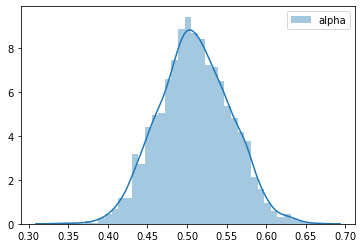

In [78]:
sns.distplot(samples['alpha'].detach().numpy(), label='alpha')
plt.legend()
plt.show()

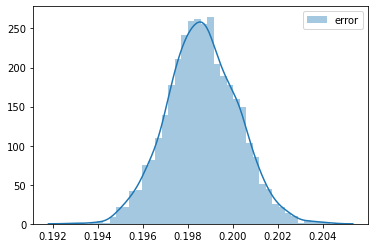

In [79]:
sns.distplot(samples['epsilon'].detach().numpy(), label='error')
plt.legend()
plt.show()

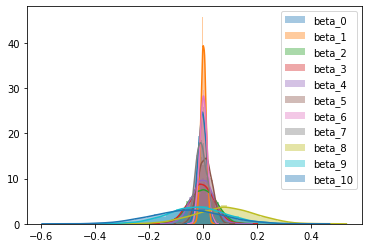

In [80]:
for d in range(X_train.shape[1]):
    sns.distplot(samples['beta'][:, d].detach().numpy())
plt.legend(['beta_%i' %i for i in range(X_train.shape[1])])
plt.show()

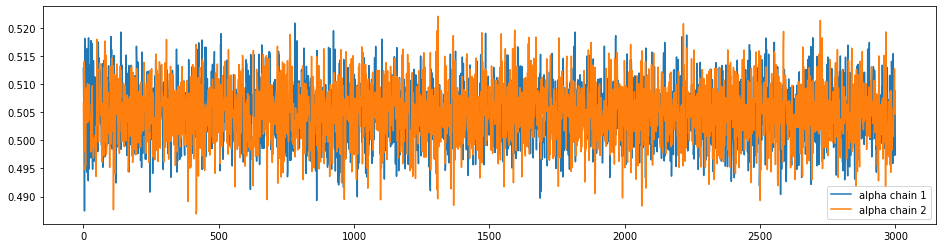

In [24]:
plt.figure(figsize=(16, 4))

plt.plot(np.arange(0, 3000 ,1), 
         samples['alpha'][0:3000].detach().numpy(), 
         label='alpha chain 1')

plt.plot(np.arange(0, 3000 ,1), 
         samples['alpha'][3000:6001].detach().numpy(), 
         label='alpha chain 2')
plt.legend()

plt.show()

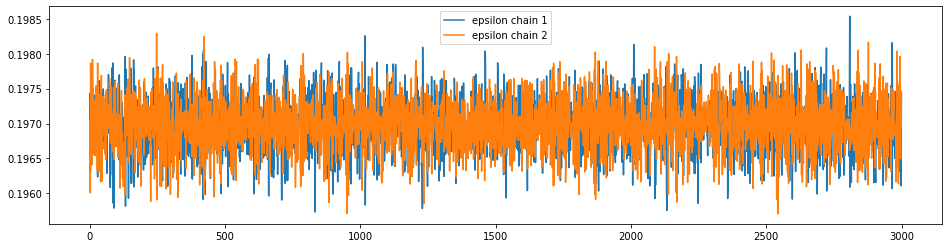

In [28]:
plt.figure(figsize=(16, 4))

plt.plot(np.arange(0, 3000 ,1), 
         samples['epsilon'][0:3000].detach().numpy(), 
         label='epsilon chain 1')

plt.plot(np.arange(0, 3000 ,1), 
         samples['epsilon'][3000:6001].detach().numpy(), 
         label='epsilon chain 2')
plt.legend()

plt.show()

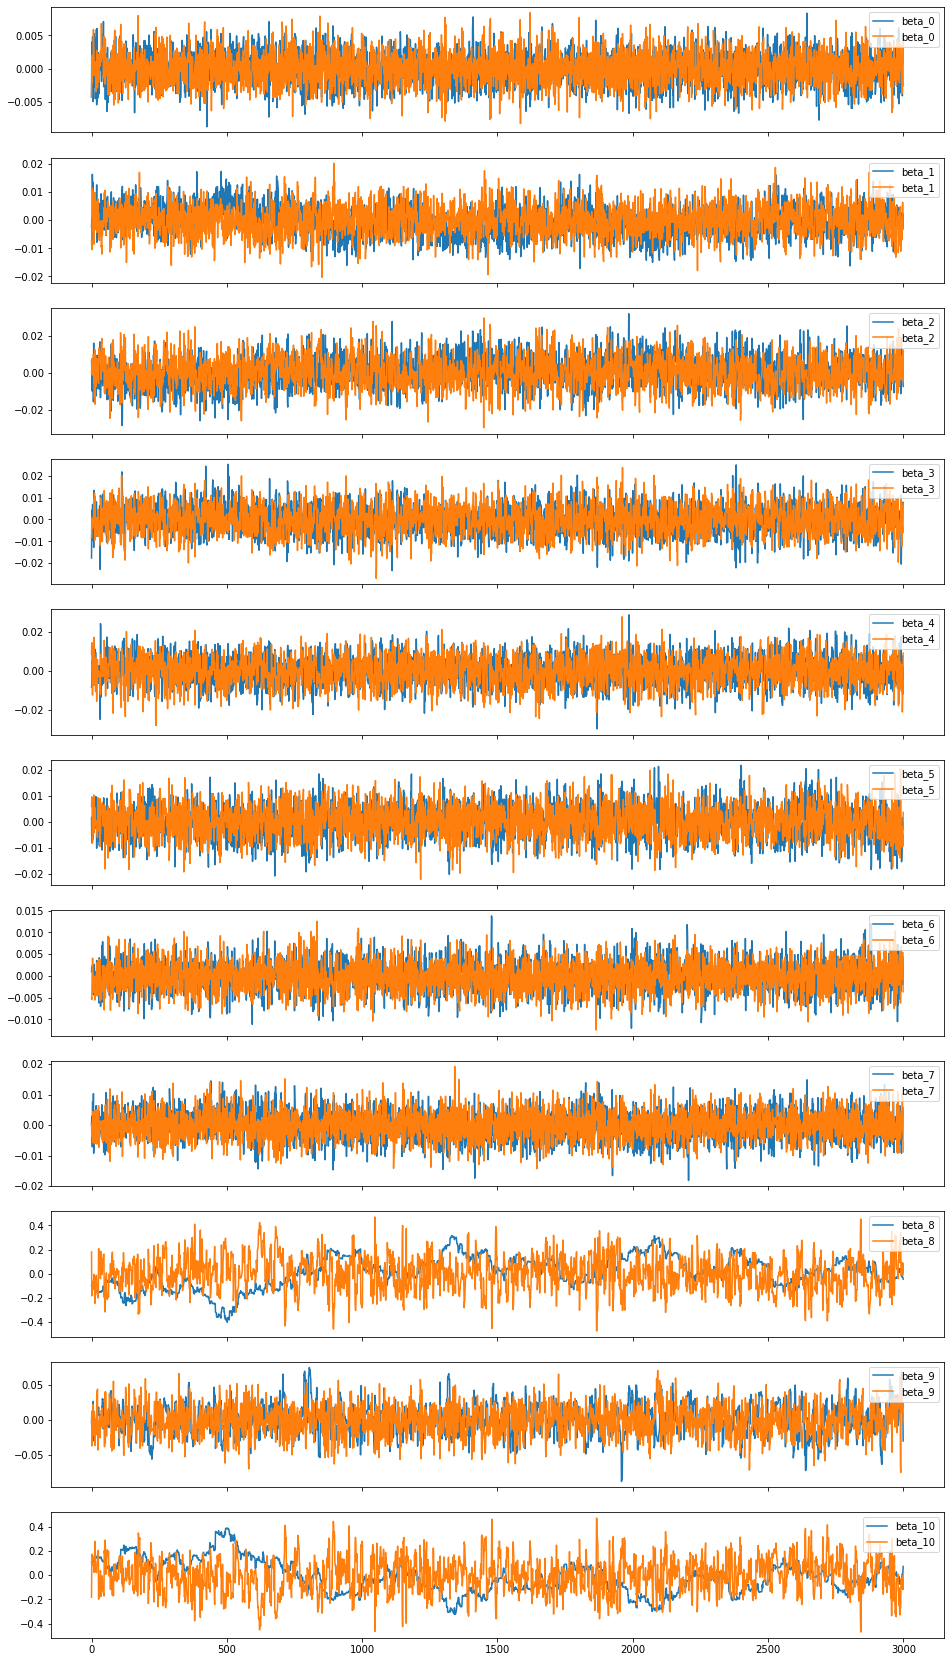

In [31]:
fig, axs = plt.subplots(len(featuers), 1,
                       figsize=(16, 30),
                       sharex=True)

for i in range(len(featuers)):
    axs[i].plot(np.arange(0, 3000, 1),
                samples['beta'][0:3000, i].detach().numpy(),
                label='beta_{}'.format(i))
    axs[i].plot(np.arange(0, 3000, 1),
                samples['beta'][3000:6001, i].detach().numpy(),
                label='beta_{}'.format(i))
    
    axs[i].legend(loc='upper right')
    
plt.show()

## Comparison with Variational Inference

In [43]:
guide = AutoMultivariateNormal(model)

pyro.clear_param_store()

n_steps = 40000

adam_params = {'lr': 0.001}
optimizer = ClippedAdam(adam_params)

elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print('[%d] ELBO: %.1f' %(step, elbo))

[0] ELBO: 243227.5
[1000] ELBO: 115974.4
[2000] ELBO: 5656.6
[3000] ELBO: -22602.3
[4000] ELBO: -20416.9
[5000] ELBO: -24183.1
[6000] ELBO: -21326.9
[7000] ELBO: -22853.0
[8000] ELBO: -24450.0
[9000] ELBO: -24355.4
[10000] ELBO: -23482.5
[11000] ELBO: -21845.3
[12000] ELBO: -24960.6
[13000] ELBO: -25213.3
[14000] ELBO: -24980.7
[15000] ELBO: -20271.1
[16000] ELBO: -23273.9
[17000] ELBO: -22490.4
[18000] ELBO: -25033.3
[19000] ELBO: -21518.2
[20000] ELBO: -25055.6
[21000] ELBO: -24211.2
[22000] ELBO: -22542.6
[23000] ELBO: -24644.8
[24000] ELBO: -25017.0
[25000] ELBO: -25000.1
[26000] ELBO: -24058.9
[27000] ELBO: -24197.8
[28000] ELBO: -24717.1
[29000] ELBO: -23874.2
[30000] ELBO: -24801.7
[31000] ELBO: -23169.6
[32000] ELBO: -24190.7
[33000] ELBO: -24968.1
[34000] ELBO: -25188.4
[35000] ELBO: -25194.6
[36000] ELBO: -24217.1
[37000] ELBO: -23045.8
[38000] ELBO: -24905.1
[39000] ELBO: -24199.7


In [45]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=guide, 
                        num_samples=3000,
                        return_sites=('alpha', 'beta', 'epsilon'))

In [46]:
samples_vi = predictive(X_train, y_train)

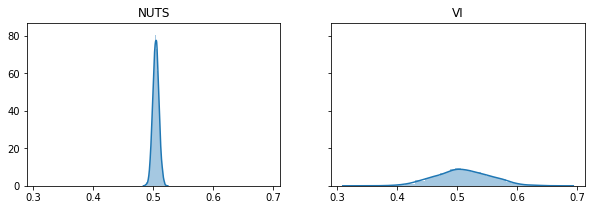

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), 
                        sharey=True, sharex=True)
sns.distplot(samples['alpha'].detach().numpy(), ax=axs[0])
sns.distplot(samples_vi['alpha'].detach().numpy(), ax=axs[1])
axs[0].set_title('NUTS')
axs[1].set_title('VI')
plt.show()

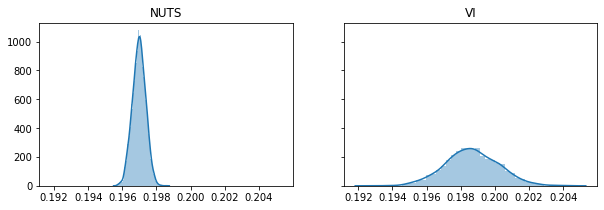

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), 
                        sharey=True, sharex=True)
sns.distplot(samples['epsilon'].detach().numpy(), ax=axs[0])
sns.distplot(samples_vi['epsilon'].detach().numpy(), ax=axs[1])
axs[0].set_title('NUTS')
axs[1].set_title('VI')
plt.show()

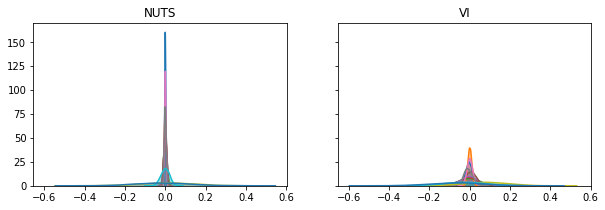

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), 
                        sharey=True, sharex=True)

for d in range(X_train.shape[1]):
    sns.distplot(samples['beta'][:, d].detach().numpy(), ax=axs[0])
    sns.distplot(samples_vi['beta'][:, d].detach().numpy(), ax=axs[1])
axs[0].set_title('NUTS')
axs[1].set_title('VI')
plt.show()